# Feature Selection: Categoricals

### Overview
Note: Focus is on Model for Women Involvment Prediction, for now.
- EDA Visualizations
    - Cross tab heat maps to show categorical features that have higher or lower women involvement
    - Cross tab heat maps to check for correlation between categorical features
    - Box plots to check for correlation between categoricals and potential numerical predictors
    
- Logistic Regression Model
    - Initial model to check coefficient sizes

- Chi Squared Test
    - Test for independence/relevance of categorical features
   

## Read Data, Import Libraries

Import Libraries:

In [194]:
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from statistics import mean
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [195]:
os.getcwd()

'C:\\Users\\trent\\Documents\\Capstone'

In [196]:
os.chdir('C:\\Users\\trent\\Documents\\Capstone')

In [197]:
train_read = pd.read_csv('Log_train_standardized.csv')

In [269]:
train_read.shape

(1374290, 112)

### Train Data: Prep for Model Building

The collapsed code below checks for null values, and removes columns with null values.

In [270]:
for i in range(len(train_read.columns)):
    if train_read.iloc[:,i].isnull().values.any() == True:
        print(train_read.iloc[:,i].name,': ',train_read.iloc[:,i].isna().sum())

patent_num :  535903
assignee :  3988
grant_yr :  535903
ipc :  617449
assignee_univ_map :  3988
Institution :  1319120
Control :  1319120
ipc_A :  617449
ipc_B :  617449
ipc_C :  617449
ipc_D :  617449
ipc_E :  617449
ipc_F :  617449
ipc_G :  617449
ipc_H :  617449


In [271]:
##drop columns not necessary for model
##dropping ipc and award data as well for now to create model
train_ = train_read.drop(['patent_num',
                   'assignee',
                   'app_num',
                   'GEOID',
                   'assignee_univ_map',
                   'Institution',
                   'Control',
                   'grant_yr',
                    # 'Award_Amount',
                    # 'Award_by_pop_gt_16_lf',
                    'ipc_A',
                    'ipc_B',
                    'ipc_C',
                    'ipc_D',
                    'ipc_E',
                    'ipc_F',
                    'ipc_G',
                    'ipc_H',
                    'num_ipcs',
                    'ipc'],
                   axis = 1)

In [31]:
for i in range(len(train_.columns)):
    if train_.iloc[:,i].isnull().values.any() == True:
        print(train_.iloc[:,i].name,': ',train_.iloc[:,i].isna().sum())

Numeric Feature List Below:

In [201]:
numeric = [
 # 'num_ipcs',
 'team_size',
 'men_inventors',
 'women_inventors',
 'Over25_Less9Grade',
 'Over25_SomeHS',
 'Over25_HSGrad',
 'Over25_SomeCollege',
 'Over25_Assosc',
 'Over25_Bach',
 'Over25_Grad',
 'ap_by_est',
 'pop_gt_16_lf',
 'est_by_pop_gt_16_lf',
 'Total_employment',
 'Pop_Est',
 'Population_Estimate',
 'Population_persons',
 'Earnings_by_place_of_work',
 'Employee_and_self-employed_contributions_for_government_social_insurance',
 'Employer_contributions_for_employee_pension_and_insurance_funds',
 'Employer_contributions_for_government_social_insurance',
 'Equals_Net_earnings_by_place_of_residence',
 'Farm_income',
 'Farm_proprietors_income',
 'Less_Contributions_for_government_social_insurance',
 'Nonfarm_personal_income',
 'Nonfarm_proprietors_income',
 'Per_capita_personal_income_dollars',
 'Personal_income_thousands_of_dollars',
 'Plus_Adjustment_for_residence',
 'Plus_Dividends_interest_and_rent',
 'Plus_Personal_current_transfer_receipts',	
 'Proprietors_employment',
 'Proprietors_income',
 'Supplements_to_wages_and_salaries',
 'Wage_and_salary_employment',
 'Wages_and_salaries',
 'Applications',
 # 'Award_Amount',
 # 'GDP_by_labor_force',
 'apps_by_pop_gt_16_lf',
 'Wages_by_pop_gt_16_lf',
 # 'Award_by_pop_gt_16_lf'
]

Categorical Feature List Below:

In [202]:
categorical = [
# 'ipc',
# 'ipc_A',
# 'ipc_B',
# 'ipc_C',
# 'ipc_D',
# 'ipc_E',
# 'ipc_F',
# 'ipc_G',
# 'ipc_H',
'already_granted',
# 'Control',
'r1',
'r2',
'special_focus',
'bea_region',
'Agriculture_Forestry_Fishing_Hunting_base',
'Mining_Quarrying_and_Oil_Gas_Extraction_base',
'Utilities_base',
'Construction_base',
'Manufacturing_base',
'Wholesale_Trade_base',
'Retail_Trade_base',
'Transportation_Warehousing_base',
'Information_base',
'Finance_Insurance_base',
'Real_Estate_Rental_Leasing_base',
'Professional_Scientific_and_Technical_Services_base',
'Management_of_Companies_Enterprises_base',
'Administrative_Support_Waste_Management_Remediation_Services_base',
'Educational_Services_base',
'Health_Care_Social_Assistance_base',
'Arts_Entertainment_and_Recreation_base',
'Accommodation_Food_Services_base',
'Other_Services_except_Public_Administration_base',
'women_involved'
]

#### One Hot Encode Categoricals
All already binary except region

In [206]:
train = pd.concat([train_.drop('bea_region', axis =1), pd.get_dummies(train_.bea_region)], axis = 1)

In [207]:
y_wi= train['women_involved']
x_wi= train.drop('women_involved', axis = 1)
y_gdp= train['GDP_by_labor_force']
x_gdp= train.drop('GDP_by_labor_force', axis = 1)

## EDA for Categorical Distribution in Women Involvement

### Overall Patents with Women Involvement for Reference/Comparison to Below Categorical Features: 24%

In [211]:
(train.women_involved.value_counts(normalize = True)*100).round(2)

0    75.97
1    24.03
Name: women_involved, dtype: float64

### BEA Region

In [205]:
region_distribution = (pd.crosstab(train_read.bea_region, train_read.women_involved, normalize = 'index')*100).round(2)

In [68]:
region_distribution.columns.name = None
region_distribution.index.name = None

In [69]:
region_distribution.rename(columns = {0:'Percent No Women Involvement', 1:'Percent Women Involved'}, inplace = True)

[Text(0.5, 1.0, 'Patents with Women Involved by Region')]

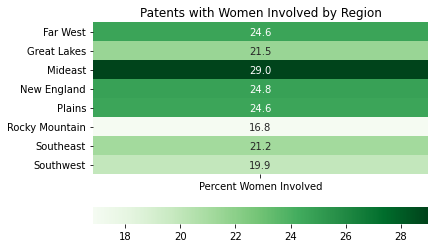

In [77]:
sns.heatmap(region_distribution.drop('Percent No Women Involvement', axis = 1), annot=True, center = region_distribution['Percent Women Involved'].mean(), cbar_kws={"orientation": "horizontal"}, cmap = "Greens", fmt = '.1f').set(title = 'Patents with Women Involved by Region')

__The Mideast region has higher than average women involvement, whereas Rocky Moutain is lower than average, the BEA region may be a meaninful predictor and provides useful interpretation.__

### Research Universities

In [208]:
research_uni = (train[['r1','r2','special_focus','women_involved']].groupby('women_involved').sum().T)

In [209]:
research_uni['Percent Patents with No Women Involvement'] = 100*(research_uni[0]/(research_uni[0]+research_uni[1])).round(2)
research_uni['Percent Patents with Women Involvement'] = 100*(research_uni[1]/(research_uni[0]+research_uni[1])).round(2)
research_uni.rename(columns = {0:'Patents with No Women Involvement', 1:'Patents with Women Involved'}, inplace = True)

In [210]:
research_uni

women_involved,Patents with No Women Involvement,Patents with Women Involved,Percent Patents with No Women Involvement,Percent Patents with Women Involvement
r1,29505,19971,60.0,40.0
r2,2320,1104,68.0,32.0
special_focus,1300,970,57.0,43.0


__Research Universities have better women invovlement, especially r1 and sepcial_focus,and r1 has a majority of the occurences. Research university appears to be a meaningful categorical predictor.__

### Industry Specialization: Industries that have a quotient above 1.0 for a GEOID

In [212]:
naics = pd.melt(train_read, id_vars = ['women_involved'], value_vars = ['Agriculture_Forestry_Fishing_Hunting_base',
'Mining_Quarrying_and_Oil_Gas_Extraction_base',
'Utilities_base',
'Construction_base',
'Manufacturing_base',
'Wholesale_Trade_base',
'Retail_Trade_base',
'Transportation_Warehousing_base',
'Information_base',
'Finance_Insurance_base',
'Real_Estate_Rental_Leasing_base',
'Professional_Scientific_and_Technical_Services_base',
'Management_of_Companies_Enterprises_base',
'Administrative_Support_Waste_Management_Remediation_Services_base',
'Educational_Services_base',
'Health_Care_Social_Assistance_base',
'Arts_Entertainment_and_Recreation_base',
'Accommodation_Food_Services_base',
'Other_Services_except_Public_Administration_base'])

In [213]:
naics.rename(columns = {'variable':'Industry'}, inplace = True)

In [214]:
naics = naics.query("value == 1")

In [215]:
naics

,women_involved,Industry,value
24,0,Agriculture_Forestry_Fishing_Hunting_base,1
38,0,Agriculture_Forestry_Fishing_Hunting_base,1
47,0,Agriculture_Forestry_Fishing_Hunting_base,1
68,0,Agriculture_Forestry_Fishing_Hunting_base,1
73,0,Agriculture_Forestry_Fishing_Hunting_base,1
...,...,...,...
26111502,0,Other_Services_except_Public_Administration_base,1
26111505,1,Other_Services_except_Public_Administration_base,1
26111507,0,Other_Services_except_Public_Administration_base,1
26111508,0,Other_Services_except_Public_Administration_base,1


[Text(0.5, 1.0, 'Patents with Women Involved by Industry Specialization')]

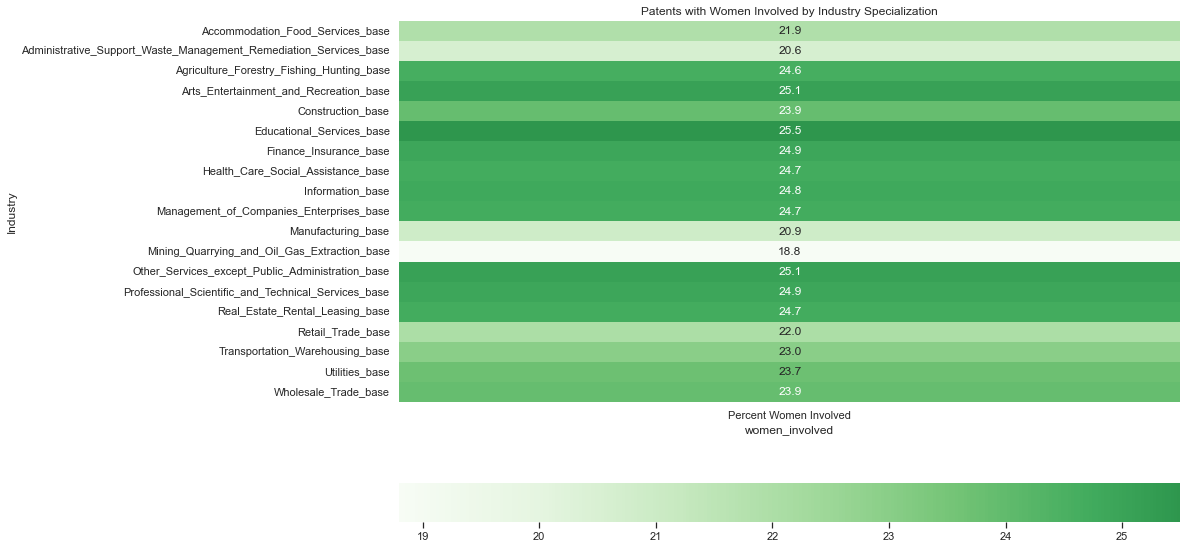

In [216]:
naics_distribution = (pd.crosstab(naics.Industry, naics.women_involved, normalize = 'index')*100).round(1)
naics_distribution.rename(columns = {0:'Percent No Women Involvement', 1:'Percent Women Involved'}, inplace = True)
# naics_distribution
sns.set(rc={'figure.figsize':(14,10)})
sns.heatmap(naics_distribution.drop('Percent No Women Involvement', axis = 1), annot=True, center = naics_distribution['Percent Women Involved'].mean(), cbar_kws={"orientation": "horizontal"}, cmap = "Greens", fmt = '.1f').set(title = 'Patents with Women Involved by Industry Specialization')

__Specialization of Industry does not appear to have a major impact with the exception of a few industries.__

## EDA for Correlation Between Categorical Predictors

In [219]:
naics_bea = pd.melt(train_read, id_vars = ['bea_region'], value_vars = ['Agriculture_Forestry_Fishing_Hunting_base',
'Mining_Quarrying_and_Oil_Gas_Extraction_base',
'Utilities_base',
'Construction_base',
'Manufacturing_base',
'Wholesale_Trade_base',
'Retail_Trade_base',
'Transportation_Warehousing_base',
'Information_base',
'Finance_Insurance_base',
'Real_Estate_Rental_Leasing_base',
'Professional_Scientific_and_Technical_Services_base',
'Management_of_Companies_Enterprises_base',
'Administrative_Support_Waste_Management_Remediation_Services_base',
'Educational_Services_base',
'Health_Care_Social_Assistance_base',
'Arts_Entertainment_and_Recreation_base',
'Accommodation_Food_Services_base',
'Other_Services_except_Public_Administration_base']).query("value == 1")

In [220]:
naics_bea

,bea_region,variable,value
24,Far West,Agriculture_Forestry_Fishing_Hunting_base,1
38,Far West,Agriculture_Forestry_Fishing_Hunting_base,1
47,Far West,Agriculture_Forestry_Fishing_Hunting_base,1
68,Far West,Agriculture_Forestry_Fishing_Hunting_base,1
73,Far West,Agriculture_Forestry_Fishing_Hunting_base,1
...,...,...,...
26111502,Far West,Other_Services_except_Public_Administration_base,1
26111505,Southwest,Other_Services_except_Public_Administration_base,1
26111507,Southeast,Other_Services_except_Public_Administration_base,1
26111508,Great Lakes,Other_Services_except_Public_Administration_base,1


In [221]:
naics_bea_xtab =  pd.crosstab(naics_bea.variable, naics_bea.bea_region, normalize = 'index')

[Text(0.5, 1.0, 'BEA Regiona and NAICS Distribution')]

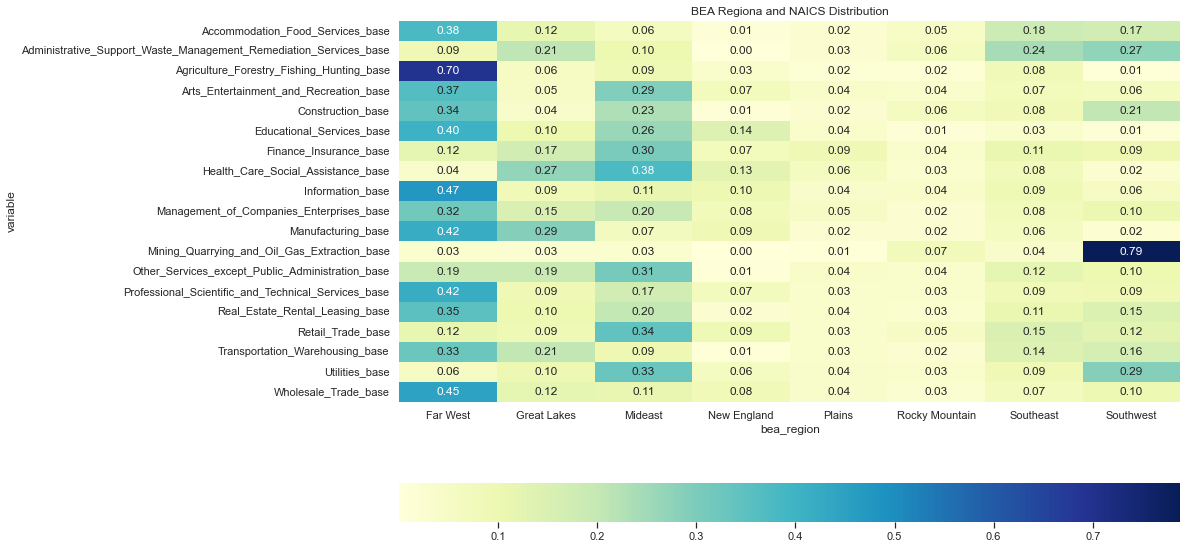

In [268]:
sns.heatmap(naics_bea_xtab, annot=True, cbar_kws={"orientation": "horizontal"}, fmt = '.2f', cmap="YlGnBu").set(title = 'BEA Regiona and NAICS Distribution')

__With a few exceptions, there is not too much evidence of correlation between regions and industry specializations__.

## Box Plots to Check for Correlation with Potential Numerical Predictors
Potential numerical predictors:
- Over25_Grad
- apps_by_pop_gt_16_lf
- Award_by_pop_gt_16_lf
- team_size
- Pop_Est
- Farm_income
- num_ipcs

### Research Univeristy Patents vs Numerical Predictors

Text(0.5, 1.0, 'Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to R1 or Not')

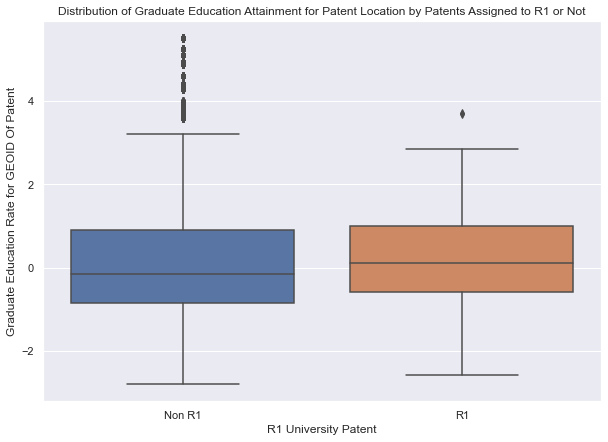

In [223]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r1', y = 'Over25_Grad', data = train_read).set_xticklabels(["Non R1","R1"])
plt.xlabel("R1 University Patent")
plt.ylabel("Graduate Education Rate for GEOID Of Patent")
plt.title("Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to R1 or Not")

Text(0.5, 1.0, 'Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to R2 or Not')

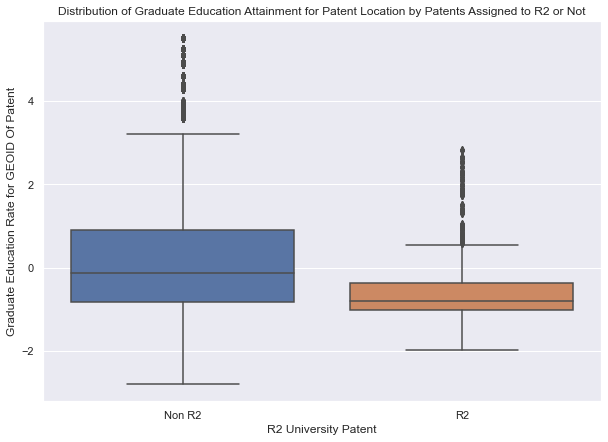

In [224]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r2', y = 'Over25_Grad', data = train_read).set_xticklabels(["Non R2","R2"])
plt.xlabel("R2 University Patent")
plt.ylabel("Graduate Education Rate for GEOID Of Patent")
plt.title("Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to R2 or Not")

Text(0.5, 1.0, 'Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to Special Focus Research University or Not')

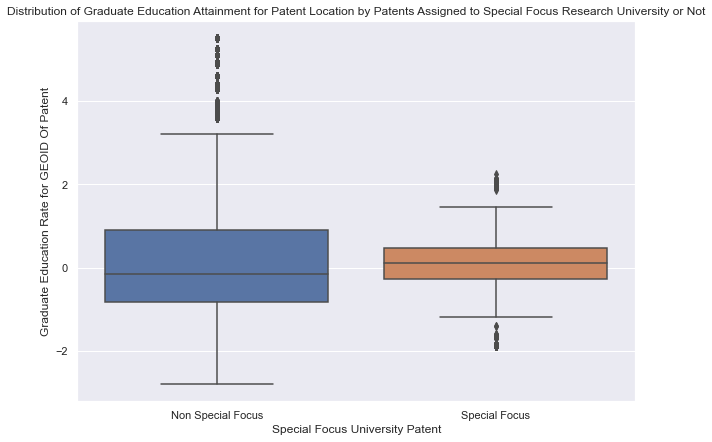

In [227]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'special_focus', y = 'Over25_Grad', data = train_read).set_xticklabels(["Non Special Focus","Special Focus"])
plt.xlabel("Special Focus University Patent")
plt.ylabel("Graduate Education Rate for GEOID Of Patent")
plt.title("Distribution of Graduate Education Attainment for Patent Location by Patents Assigned to Special Focus Research University or Not")

__Because the size of the research univeristies is small compared to overall set, the correlation may be negligble here. Will just look at R1 university classification hereafter.__

Text(0.5, 1.0, 'Distribution of Business Applications/Population for Patents From or Not From R1 Universities')

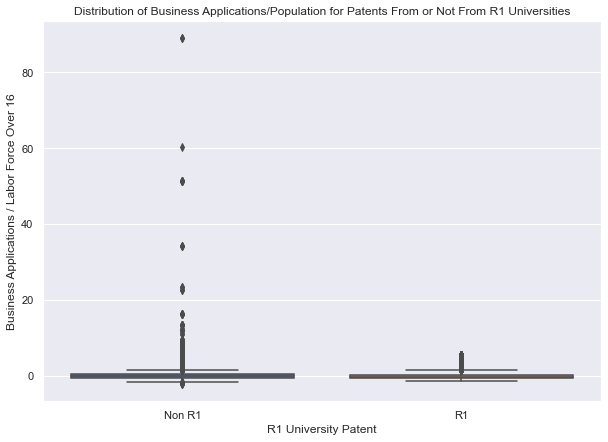

In [226]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r1', y = 'apps_by_pop_gt_16_lf', data = train_read).set_xticklabels(["Non R1","R1"])
plt.xlabel("R1 University Patent")
plt.ylabel("Business Applications / Labor Force Over 16")
plt.title("Distribution of Business Applications/Population for Patents From or Not From R1 Universities")

Text(0.5, 1.0, 'Distribution of Award/Population for Patents From or Not From R1 Universities')

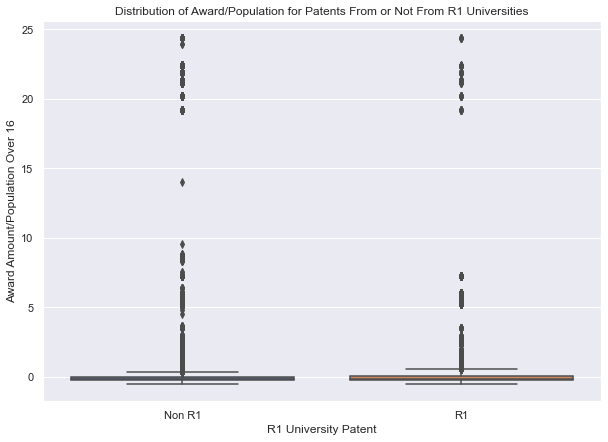

In [260]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r1', y = 'Award_by_pop_gt_16_lf', data = train_read).set_xticklabels(["Non R1","R1"])
plt.xlabel("R1 University Patent")
plt.ylabel("Award Amount/Population Over 16")
plt.title("Distribution of Award/Population for Patents From or Not From R1 Universities")

Text(0.5, 1.0, 'Distribution of Team Size for Patents From or Not From R1 Universities')

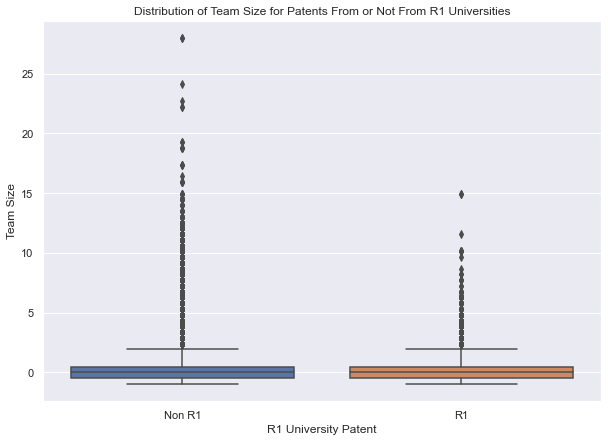

In [261]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r1', y = 'team_size', data = train_read).set_xticklabels(["Non R1","R1"])
plt.xlabel("R1 University Patent")
plt.ylabel("Team Size")
plt.title("Distribution of Team Size for Patents From or Not From R1 Universities")

Text(0.5, 1.0, 'Distribution of GEOID Population Estiamte for Patents From or Not From R1 Universities')

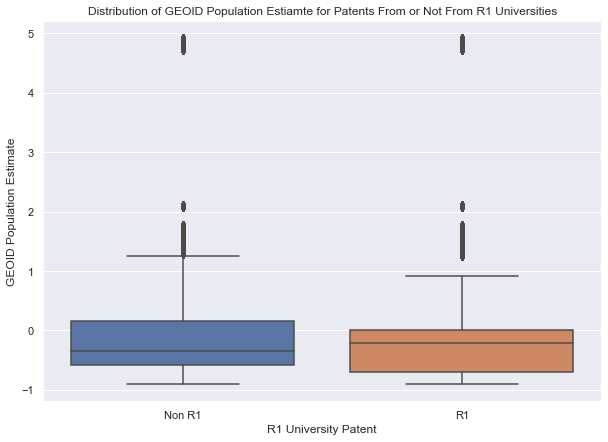

In [263]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'r1', y = 'Pop_Est', data = train_read).set_xticklabels(["Non R1","R1"])
plt.xlabel("R1 University Patent")
plt.ylabel("GEOID Population Estimate")
plt.title("Distribution of GEOID Population Estiamte for Patents From or Not From R1 Universities")

Text(0.5, 1.0, 'Distribution of Graduate Education Attainment for Patent Location by BEA Region')

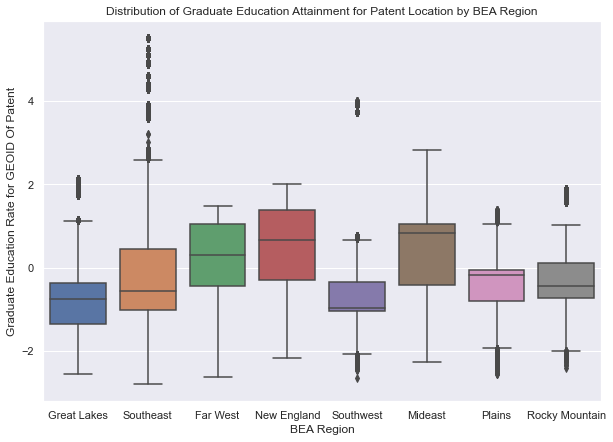

In [264]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'bea_region', y = 'Over25_Grad', data = train_read)
plt.xlabel("BEA Region")
plt.ylabel("Graduate Education Rate for GEOID Of Patent")
plt.title("Distribution of Graduate Education Attainment for Patent Location by BEA Region")

Text(0.5, 1.0, 'Distribution of Business Applications/Population for Patent Location by BEA Region')

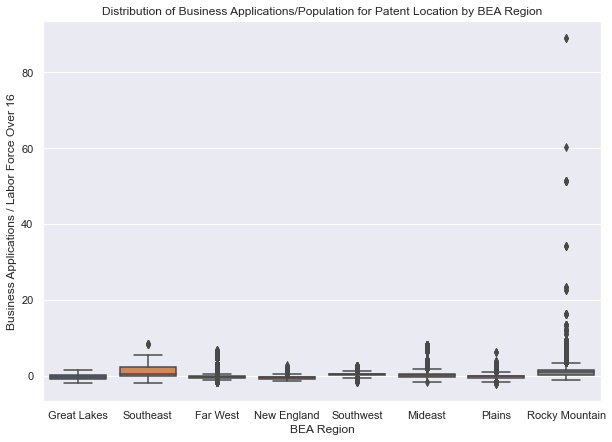

In [265]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'bea_region', y = 'apps_by_pop_gt_16_lf', data = train_read)
plt.xlabel("BEA Region")
plt.ylabel("Business Applications / Labor Force Over 16")
plt.title("Distribution of Business Applications/Population for Patent Location by BEA Region")

Text(0.5, 1.0, 'Distribution of Award/Population for Patent Location by BEA Region')

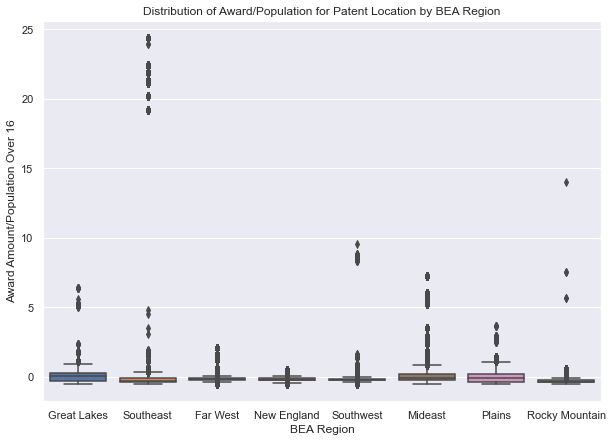

In [266]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'bea_region', y = 'Award_by_pop_gt_16_lf', data = train_read)
plt.xlabel("BEA Region")
plt.ylabel("Award Amount/Population Over 16")
plt.title("Distribution of Award/Population for Patent Location by BEA Region")

Text(0.5, 1.0, 'Distribution of Patent Team Size by BEA Region')

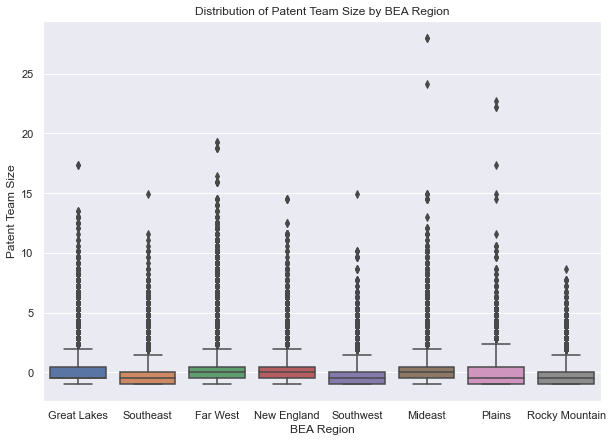

In [267]:
plt.figure(figsize = (10,7))
sns.boxplot(x = 'bea_region', y = 'team_size', data = train_read)
plt.xlabel("BEA Region")
plt.ylabel("Patent Team Size")
plt.title("Distribution of Patent Team Size by BEA Region")

## Feature Importance

### Simple Logistic Regression Model

In [228]:
categorical = [
# 'ipc',
# 'ipc_A',
# 'ipc_B',
# 'ipc_C',
# 'ipc_D',
# 'ipc_E',
# 'ipc_F',
# 'ipc_G',
# 'ipc_H',
'already_granted',
# 'Control',
'r1',
'r2',
'special_focus',
# 'bea_region',
'Agriculture_Forestry_Fishing_Hunting_base',
'Mining_Quarrying_and_Oil_Gas_Extraction_base',
'Utilities_base',
'Construction_base',
'Manufacturing_base',
'Wholesale_Trade_base',
'Retail_Trade_base',
'Transportation_Warehousing_base',
'Information_base',
'Finance_Insurance_base',
'Real_Estate_Rental_Leasing_base',
'Professional_Scientific_and_Technical_Services_base',
'Management_of_Companies_Enterprises_base',
'Administrative_Support_Waste_Management_Remediation_Services_base',
'Educational_Services_base',
'Health_Care_Social_Assistance_base',
'Arts_Entertainment_and_Recreation_base',
'Accommodation_Food_Services_base',
'Other_Services_except_Public_Administration_base',
# 'women_involved'
'Far West',
'Great Lakes', 
'Mideast', 
'New England', 
'Plains', 
'Rocky Mountain',
'Southeast', 
'Southwest'
]

In [231]:
model = LogisticRegression(solver='liblinear')
logreg = model.fit(x_wi[categorical], y_wi)
# evaluate the model
# yhat = model.predict(x_wi)
# # evaluate predictions
# accuracy = accuracy_score(y_test, yhat)
# print('Accuracy: %.2f' % (accuracy*100))

In [256]:
coef_dict = {}
for coef, feat in zip(logreg.coef_[0,:],categorical):
    coef_dict[feat] = coef
log_reg_params = pd.DataFrame(coef_dict.items(),columns = ['feature','coefficient'])  

In [251]:
log_reg_params.sort_values(by = 'coefficient', key = abs, ascending = False)

,feature,coefficient
1,r1,0.814007
3,special_focus,0.787194
2,r2,0.624332
28,Rocky Mountain,-0.455528
30,Southwest,-0.231136
8,Manufacturing_base,-0.196560
5,Mining_Quarrying_and_Oil_Gas_Extraction_base,-0.178793
17,Administrative_Support_Waste_Management_Remedi...,-0.177686
10,Retail_Trade_base,-0.173443
29,Southeast,-0.173203


### Chi Squared Test
Test for independence between categorical variables. The larger the score the more relevant the feature is.

First filtering for the latest categoricals after one hot encoding:

In [28]:
# x_wi[categorical]

In [252]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_wi[categorical], y_wi)
X_train_fs = fs.transform(x_wi[categorical])

In [257]:
# for i in range(len(fs.scores_)):
#     print(fs.feature_names_in_[i],'Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    # plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    # plt.show()
score_dict = {}
for i in range(len(fs.scores_)):
    score_dict[fs.feature_names_in_[i]] = fs.scores_[i]
chi_scores = pd.DataFrame(score_dict.items(),columns = ['feature','score'])  

In [259]:
chi_scores.sort_values('score', ascending = False)

,feature,score
1,r1,7232.291502
25,Mideast,3492.140504
8,Manufacturing_base,2199.282439
17,Administrative_Support_Waste_Management_Remedi...,1336.320994
28,Rocky Mountain,1205.501813
30,Southwest,1154.908610
5,Mining_Quarrying_and_Oil_Gas_Extraction_base,1067.900249
21,Accommodation_Food_Services_base,870.959409
10,Retail_Trade_base,829.034504
18,Educational_Services_base,759.900592


__R1 is definitely an important feature- some industry specializations may be important, may need to include all or none__

#### Recursive Feature Elimination

In [ ]:
rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = 10)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
cv = RepeatedStratifiedKFold(n_splites = 10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, x_wi, y_wi, scoring = 'accuracy', cv = cv, n_jobs=-1)


### Numerical - Women Involvement

#### Anova F Test

In [ ]:
fs = SelectKBest(k='all')
fs.fit(x_wi[numeric], y_wi)
X_train_fs = fs.transform(x_wi[numeric])

for i in range(len(fs.scores_)):
    print(fs.feature_names_in_[i],'Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    # plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    # plt.show()

team_size Feature 0: 217239.557043
men_inventors Feature 1: 6413.022931
women_inventors Feature 2: 4313000.261570
Over25_Less9Grade Feature 3: 0.002827
Over25_SomeHS Feature 4: 2310.601329
Over25_HSGrad Feature 5: 2530.228534
Over25_SomeCollege Feature 6: 7890.419521
Over25_Assosc Feature 7: 3708.346035
Over25_Bach Feature 8: 3261.616918
Over25_Grad Feature 9: 8036.418915
ap_by_est Feature 10: 2055.820773
pop_gt_16_lf Feature 11: 74.420270
est_by_pop_gt_16_lf Feature 12: 1942.412615
Total_employment Feature 13: 1.617859
Pop_Est Feature 14: 119.823406
Population_Estimate Feature 15: 124.223970
Population_persons Feature 16: 124.198317
Earnings_by_place_of_work Feature 17: 151.496958
Employee_and_self-employed_contributions_for_government_social_insurance Feature 18: 134.262198
Employer_contributions_for_employee_pension_and_insurance_funds Feature 19: 143.760705
Employer_contributions_for_government_social_insurance Feature 20: 183.650467
Equals_Net_earnings_by_place_of_residence Featur

Tuning number of selected features:

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
fs = SelectKBest()
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])

In [ ]:
grid = dict()
grid['anova__k'] = [i+1 for i in range(5)]

In [ ]:
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(x_wi[numeric], y_wi)